In [0]:
import torch
from torch.utils.data import DataLoader
from datetime import datetime
from torch.utils.data import random_split
from torch import nn
import numpy as np
from torch.optim.lr_scheduler import ExponentialLR
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
### FUNCTIONS TO LOAD DATA FROM CHRIS'S THING (don't run this cell) ###
from CountyDataset import (
    CountyDataset,
)
def get_dataset(master_path):
    dataset = CountyDataset(master_path)
    X, Y = next(iter(dataset))

    print('-'*89)
    print('Total Dataset Summary')
    print('-'*89)

    print(f'total samples {len(dataset):,} '
          f'X {X.size()} | Y {Y.size()}')

    return dataset

def get_numpy(dataset):
    data = []
    for i in range(len(dataset)):
        X, Y = dataset[i]
        data.append((X.numpy(), Y.numpy()))

    print('-'*89)
    print(f'Numpy Dataset Summary')
    print('-'*89)
    X, Y = zip(*data)
    print(f'total samples {len(X)} '
          f'| input time periods {len(X[0])} '
          f'| input features {X[0].shape[1]} '
          f'| output time periods {len(Y[0])}'
          f'| target col {dataset.target_col}')

    return data, dataset.xcols, dataset.target_col, dataset.date_index



In [0]:
### LOAD DATASET FROM CHRIS'S THING (also don't run this cell) ###
master_path = 'utils/data/county_table.csv'
data = get_numpy(get_dataset(master_path))

# save data to pickle file
import pickle
with open('dataset.pickle', 'wb') as handle:
    pickle.dump(data[0], handle)

NameError: ignored

In [0]:
### LOAD DATA FROM PICKLE FILES ###
# change file paths to wherever the pickled data files are stored
import pickle
with open('drive/My Drive/DL project/datasets/test_12_3.pickle', 'rb') as handle:
    test_dataset = pickle.load(handle)
with open('drive/My Drive/DL project/datasets/train_12_3.pickle', 'rb') as handle:
    train_dataset = pickle.load(handle)
with open('drive/My Drive/DL project/datasets/val_12_3.pickle', 'rb') as handle:
    val_dataset = pickle.load(handle)

num_months = 12 ## change this line as necessary to the number of training months per instance

# this bit gets rid of all the incomplete series (i.e. those with less than num_months months)
train_dataset = [data for data in train_dataset if len(data[0]) == num_months]
test_dataset = [data for data in test_dataset if len(data[0]) == num_months]
val_dataset = [data for data in val_dataset if len(data[0]) == num_months]

In [0]:
# make DataLoaders for each of the splits of the data
train_loader = DataLoader(train_dataset, batch_size=512,
                          shuffle=False, pin_memory=False,
                          num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1,
                          shuffle=False, pin_memory=False,
                          num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=512,
                          shuffle=False, pin_memory=False,
                          num_workers=4)

In [0]:
### train, val, and test functions for main training loop ###
def train(model, train_loader, optimizer, loss_function, epoch, device=None):
    model.train()
    for idx, (X_train, y_train) in enumerate(train_loader):
        if device is not None:
            X_train, y_train = X_train.to(device), y_train.to(device)

        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = torch.sqrt(loss_function(y_pred, y_train)) # loss is RMSE of log prices
        loss.backward()
        optimizer.step()

    return loss.item()

def val(model, val_loader, loss_function, device=None):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for idx, (X_val, y_val) in enumerate(val_loader):
            if device is not None:
                X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val)
            loss = torch.sqrt(loss_function(y_pred, y_val)).item()
            val_loss += [loss]
    return np.mean(val_loss)

def test(model, test_loader, loss_function, device=None):
    model.eval()
    test_loss = []
    mape = 0  # commented out stuff gives MAPE metric - 
                # maybe we record this as well since it's more interpratable
    with torch.no_grad():
        for idx, (X_test, y_test) in enumerate(test_loader):
            if device is not None:
                X_test, y_test = X_test.to(device), y_test.to(device)
            y_pred = model(X_test)
            y_pred_actual = torch.exp(y_pred)
            y_test_actual = torch.exp(y_test)
            mape += torch.mean(torch.abs(y_test_actual - y_pred_actual) / y_test_actual)

            ## uncomment the next three lines to have the test print a few prices & predictions
            if idx % 1000 == 0: # this bit just prints a few actual prices
                print('{}   \t{}'.format(torch.exp(y_pred).cpu().numpy(),
                                      torch.exp(y_test).cpu().numpy()))
                
            loss = torch.sqrt(loss_function(y_pred, y_test)).item()
            test_loss += [loss]
        mape /= len(test_loader.dataset)
    return np.mean(test_loss), (mape.item() * 100)



In [7]:
### TRAINING ###
device = 'cuda' # use GPU; change from 'cuda' to None for CPU

# training parameters
num_epochs = 10 # pick 10, 50, 100
hidden_dim = 10 # pick 10, 50, 100
learning_rate = .01 # pick .01, .001
months_to_predict = 3 # either 1, 3, or 6 depending on dataset

### PICK A MODEL ###
# don't forget to update the import line to whatever path the model file is stored at
from LSTM import LSTM
model = LSTM(input_dim=235, hidden_dim=hidden_dim, output_dim=months_to_predict, num_layers=2)

# from RNN import RNN
# model = RNN(D_in=235, H=hidden_dim, D_out=months_to_predict, L=1, dropout=0.0, device=device)

if device is not None:
    model.to(device)

# set up optimizer, etc.
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optimizer, gamma=.95)

print('Epoch\tTrain RMSE\tVal RMSE\tTime Elapsed')
print('----------------------------------------------------')
# main training loop
train_losses = []
val_losses = []
for i in range(num_epochs):
    start = time.time()
    train_loss = train(model, train_loader, optimizer, loss_function, i+1, device=device)
    train_losses += [train_loss]
    val_loss = val(model, val_loader, loss_function, device=device)
    val_losses += [val_loss]
    scheduler.step()
    time_elapsed = time.time() - start
    print('{}\t{:.6f}\t{:.6f}\t{:.3f}s'.format(i+1, train_loss, val_loss, time_elapsed))

Epoch	Train RMSE	Val RMSE	Time Elapsed
----------------------------------------------------
1	0.369819	0.428818	3.977s
2	0.304295	0.321513	3.721s
3	0.308736	0.283378	3.716s
4	0.153631	0.232467	3.747s
5	0.165415	0.219935	3.743s
6	0.164885	0.226631	3.700s
7	0.155999	0.206211	3.762s
8	0.149469	0.191592	3.702s
9	0.148506	0.194407	3.790s
10	0.147035	0.192271	3.786s


In [24]:
### TESTING ###
start = time.time()
test_loss, test_mape = test(model, test_loader, loss_function, device=device)
time_elapsed = time.time() - start
print('Test RMSE: {:.6f}\t Test MAPE: {:.3f}%'.format(test_loss, test_mape))
print('Time Elapsed: {:.3f}'.format(time_elapsed))

[[73110.9  70443.43 70886.86]]   	[[70815.984 70803.016 70743.016]]
[[98382.78  98041.3   98425.766]]   	[[62165.984 62255.99  62260.023]]
[[86101.51 83803.28 84323.98]]   	[[56992.992 57180.98  57349.02 ]]
[[197635.47 198460.66 199541.84]]   	[[208582.08 208581.08 208462.95]]
[[179527.12 176661.42 177875.73]]   	[[190155.   190431.94 190901.06]]
[[215710.7  215400.7  216591.53]]   	[[347422.84 346862.06 345717.06]]
[[182493.1  179561.03 180805.98]]   	[[133354.97 134905.95 136376.98]]
[[103215.64 100108.17 101194.66]]   	[[88693.04 88775.04 89124.96]]
[[77037.35 73840.91 74486.87]]   	[[87781.04  88137.97  88313.984]]
[[82761.17 80621.88 81089.71]]   	[[87415.97 87622.96 87852.98]]
[[64340.414 60675.316 61139.07 ]]   	[[54334.984 54272.01  54361.   ]]
[[181886.7  178856.38 180111.2 ]]   	[[261136.97 262772.03 264568.9 ]]
[[325397.38 318394.12 321099.78]]   	[[387689.1  389445.97 391455.97]]
[[86512.4  83581.71 84396.23]]   	[[80868.99  81104.016 81481.96 ]]
[[105582.945 106374.62  106

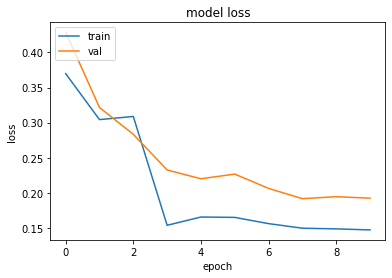

In [12]:
### PLOTTING ###
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()